In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import minimize 

In [2]:
data_path = "ex2data2.txt"
with open(data_path, "r", newline="") as file:
    reader = csv.reader(file)
    data = np.array(list(reader), dtype=float)
    
print(data.shape)
data[:5]

(162, 3)


array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ],
       [-0.21371 ,  0.69225 ,  1.      ],
       [-0.375   ,  0.50219 ,  1.      ],
       [-0.51325 ,  0.46564 ,  1.      ]])

In [3]:
X = np.reshape(data[:,0:2], (-1,2))
y = np.reshape(data[:,2], (-1,1))
m = y.shape[0]
print(X.shape)
print(y.shape)

(162, 2)
(162, 1)


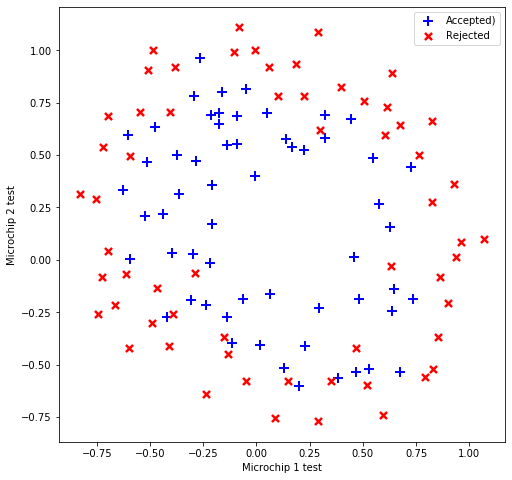

In [4]:
X_pos = X[np.where(y[:,0]==1)]
X_neg = X[np.where(y[:,0]==0)]

plt.figure(figsize=(8,8))
plt.xlabel('Microchip 1 test')
plt.ylabel('Microchip 2 test')
plt.scatter(X_pos[:,0], X_pos[:,1], marker = '+', linewidth=10, s=5, c='b', label='Accepted)')
plt.scatter(X_neg[:,0], X_neg[:,1], marker = 'x', linewidth=10, s=3, c='r', label='Rejected')
plt.legend()
plt.show()

In [5]:
def map_feature(x1, x2):
    degree = 6
    m = x1.shape[0]
    out = np.ones((m, 1))
    for i in range(1, degree+1):
        for j in range(i+1):
            new = (x1**(i-j))*(x2**j)
            out = np.hstack([out, new.reshape([m, 1])])
            
    return out

In [6]:
X_1 = X.copy()
X_1 = map_feature(X[:,0], X[:,1])
X_1 = np.append(np.ones([m,1]), X_1, axis=1)

print(X_1.shape)

(162, 29)


In [7]:
y[0:].shape

(162, 1)

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

sigmoid(np.array([[0, 1, 2],[0, -1, -2]]))

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

### Computing Regularize Cost Function and Gradient

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \Theta_j^2$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\Theta)}{\partial \Theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\Theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\Theta_j$ for $j\geq 1$

In [9]:
def cost_func(theta, X, y, lamb):  
    m=len(y)
    inner_theta = np.expand_dims(theta, axis=1) #for J, not for h
    h = sigmoid(X @ inner_theta)
    J = (1/m) * (np.dot((-y.T), np.log(h)) - np.dot((1-y.T), np.log(1-h)))
    reg_J = J + (lamb/(2*m))*np.dot(inner_theta[1:].T, inner_theta[1:])    
    return reg_J[0]

def grad_func(theta, X, y, lamb):
    inner_theta = np.expand_dims(theta, axis=1)
    m = y.shape[0]
    h = sigmoid(X @ inner_theta)
    grad = (1/m) * np.dot((h-y).T, X).T
    grad[1:] += (lamb/m) * inner_theta[1:]
    return grad[:,0]

In [10]:
m, n = X_1.shape

initial_theta = np.zeros(n)
print("theta shape: ", initial_theta.shape)
lamb = 1e-5

cost = cost_func(initial_theta, X_1, y, lamb)
grad = grad_func(initial_theta, X_1, y, lamb)

print('Cost at initial theta (zeros):\n', cost)

print('Gradient shape at initial theta (zeros):\n', grad.shape)

theta shape:  (29,)
Cost at initial theta (zeros):
 [0.69314718]
Gradient shape at initial theta (zeros):
 (29,)


### Optimization using scipy's minimize

In [11]:
result = minimize(cost_func, initial_theta, method='BFGS', jac=grad_func,
                  args=(X_1, y, lamb), options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.248390
         Iterations: 366
         Function evaluations: 367
         Gradient evaluations: 367


In [12]:
print('Cost :\n', cost_func(result.x, X_1, y, lamb))
theta_1 = result.x

Cost :
 [0.2483902]


In [13]:
def predict(theta, X):
    return np.around(sigmoid(X.dot(theta)))

In [14]:
pred = predict(result.x, X_1)
print("acc: ", np.count_nonzero(pred == y[:,0])/m)

acc:  0.8950617283950617


### Optimization using handwritten gradient descent

In [15]:
def gradient_descent(X,y,theta,alpha,num_iters,lamb):
    m=len(y)
    J_history = []
    
    for i in range(num_iters):
        cost = cost_func(theta, X, y, lamb)   
        grad = grad_func(theta, X, y, lamb)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta, J_history


theta_2, J_history = gradient_descent(X_1, y, initial_theta, 1, 800, lamb) #0.1, 1000, 1

print("The regularized theta using ridge regression:\n",theta_2)
print('Cost :\n', cost_func(theta_2, X_1, y, lamb))

The regularized theta using ridge regression:
 [ 1.8175052   1.81743663  2.09477908  3.08434079 -4.89780602 -4.17854797
 -4.59820392  0.88932133 -1.57584559 -1.12011673  0.08943495 -4.03160346
  0.06470719 -2.11177589 -1.39344199 -3.16820111 -0.55002846 -0.73012261
  0.25923414 -1.14137581 -1.37878437 -0.15682544 -3.14631804  0.29121461
 -0.97764436  0.26766503 -1.23317603 -0.93843505 -1.79472772]
Cost :
 [0.32497094]


In [16]:
pred = predict(theta_2, X_1)
print("acc: ", np.count_nonzero(pred == y[:,0])/m)
cost = cost_func(theta_2, X_1, y, lamb)
cost

acc:  0.8703703703703703


array([0.32497094])

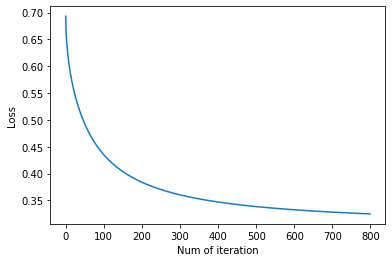

In [17]:
plt.plot(J_history)
plt.xlabel('Num of iteration')
plt.ylabel('Loss')
plt.show()

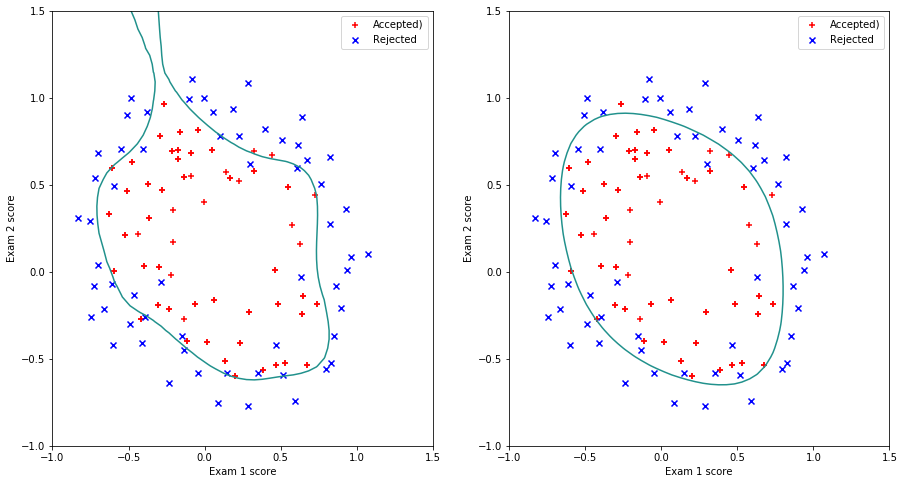

In [18]:
def mapFeaturePlot(x1,x2,degree):
    out = np.ones(1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms = (x1**(i-j) * x2**j)
            out = np.hstack((out,terms))
    out = np.insert(out, 0, 1, axis=0)
    return out

u_vals = np.linspace(-1,1.5,50)
v_vals = np.linspace(-1,1.5,50)
z_1 = np.zeros((len(u_vals),len(v_vals)))
z_2 = np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        map_feat = mapFeaturePlot(u_vals[i],v_vals[j],6)
        z_1[i,j] = map_feat @ theta_1
        z_2[i,j] = map_feat @ theta_2
        
z = [z_1, z_2]
plt.figure(figsize=(15,8))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.xlabel('Microchip 1 test')
    plt.ylabel('Microchip 2 test')
    plt.scatter(X_pos[:,0], X_pos[:,1], marker = '+', c='r', label='Accepted)')
    plt.scatter(X_neg[:,0], X_neg[:,1], marker = 'x', c='b', label='Rejected')

    plt.contour(u_vals,v_vals,z[i].T,0)
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.legend(loc=0)

plt.show()

# Lasso Regression

$J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\Theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\Theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n |\Theta_j|$

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l1")
clf.fit(X_1,y)

theta_lasso=clf.coef_
print("The regularized theta using lasso regression:\n",
      theta_lasso.reshape(29,1))

The regularized theta using lasso regression:
 [[ 0.59306587]
 [ 1.54594637]
 [ 0.99049697]
 [ 1.5203491 ]
 [-5.0533112 ]
 [-2.81225551]
 [-3.45668827]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-1.31980007]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-2.03164019]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


/home/misha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/misha/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
pred = predict(theta_lasso.T, X_1)
print("acc: ", np.count_nonzero(pred == y[:,0])/m)

acc:  86.18518518518519
